In [1]:
from refexps import load_data, move_level, gamerun_level, get_previous #, lex_sim
from os import listdir, path
from itertools import combinations
from collections import defaultdict
import numpy as np
from scipy import stats
import compound_splitter
from nltk import word_tokenize
from string import punctuation
punct = list(punctuation)

In [2]:
def exp_len(exp, language, splits):
    '''
    Extract content words by the phrase
    :param exp: referring expression tuple
    :return: set of content words of the phrase
    '''
    exp = exp[2]
    words = word_tokenize(exp, language)
    if language == 'german':
        words_nocomp = []
        for w in words:
            word = compound_splitter.split_word(w, splits)
            words_nocomp = words_nocomp + (word.split(' '))	
            words = words_nocomp
    return len(words)

def len_div(exp1, exp2, language, splits):
    '''
    compute dice similarity between the content words in two referring expression
    :param exp1: referring expression tuple 1
    :param exp2: referring expression tuple 2
    :return: dice similarity between the content words in the expressions; undefined if they have none
    '''        
    len1 = exp_len(exp1, language, splits)    
    len2 = exp_len(exp2, language, splits)
    if len1 + len2 == 0:
        return 'undefined'
    metric = float(len1 - len2)/float(len1 + len2)

    return metric if not np.isnan(metric) and metric > -1  and metric < 1 else 'undefined'

In [3]:
def compute_values_move(refexps_dir, success_dir):
    splits = compound_splitter.load_dict('de_lower.dict')
    move_level_data = defaultdict(dict)
    move_level_align = []
    move_level_coherence = []
    success_types = set()
    playermove_level_align_speaker = defaultdict(list)
    playermove_level_coherence_speaker= defaultdict(list)

    for dialogue in listdir(refexps_dir):
        #extract dialogue type
        success_file = dialogue.replace('refexps', 'movesuccess')
        success_file = path.join(success_dir, success_file)
        if dialogue.startswith('FTT'):
            language = 'german'
        else:
            language = 'english'
        dialogue = path.join(refexps_dir, dialogue)
        #load referring expressions data
        dialogue = load_data(dialogue)
        success_moves = load_data(success_file)
        #move level
        dialogue_move = move_level(dialogue)
        #iterate over moves
        for move in dialogue_move:
            refs = move[1]
            #iterate over objects
            for obj in refs:
                #iterate over objects
                refobj = refs[obj]
                #SIMILARITY OF LEXICAL CONTENT INTO
                sim_align = []
                sim_align_speaker = defaultdict(list)
                sim_coherence_speaker = defaultdict(list)
                sim_coherence = []
                for ref in refobj:
                    speaker = ref[1]
                    sim = len_div(ref, get_previous(ref, refobj), language, splits) ###
                    if sim != 'undefined':
                        sim_align.append(sim)
                        sim_align_speaker[speaker].append(sim)
                sim_align = np.mean(sim_align)
                comb_ref = combinations(refobj,2)
                for comb in comb_ref:
                    if comb[0] != comb[1]:
                        sim = len_div(comb[0], comb[1], language, splits) ###
                        if sim != 'undefined':
                            sim_coherence.append(sim)
                            sim_coherence_speaker[comb[0][1]].append(sim)
                            sim_coherence_speaker[comb[1][1]].append(sim)
                sim_coherence = np.mean(sim_coherence)
                #movelevel coherence and alignment (for each object)
                if not np.isnan(sim_coherence):
                    move_level_coherence.append(sim_coherence)
                if not np.isnan(sim_align):
                    move_level_align.append(sim_align)
                for s in sim_align_speaker:
                    if not np.isnan(np.mean(sim_align_speaker[s])):
                        playermove_level_align_speaker[s].append(np.mean(sim_align_speaker[s]))
                for s in sim_coherence_speaker:
                    if not np.isnan(np.mean(sim_coherence_speaker[s])) :
                        playermove_level_coherence_speaker[s].append(np.mean(sim_coherence_speaker[s]))
            values = [sim_coherence, sim_align, sim_align_speaker['e-utts'], sim_align_speaker['p-utts'], 
                      sim_coherence_speaker['e-utts'], sim_coherence_speaker['p-utts'] ]
            move_level_data[move[0]]['values'] = values
            success = success_moves[move[0]]
            move_level_data[move[0]]['success'] = success
    move_level_align_all = []
    move_level_coherence_all = []

    playermove_level_align_speaker_all = defaultdict(list)
    playermove_level_coherence_speaker_all = defaultdict(list)

    results_move = defaultdict(list)
    
    playermove_level_coherence = []
    for s in playermove_level_coherence_speaker:
        playermove_level_coherence += playermove_level_coherence_speaker[s]
        playermove_level_coherence_speaker_all[s] += playermove_level_coherence_speaker[s]
        results_move['Move coherence '+ s] = playermove_level_coherence_speaker[s]
    results_move['Move players coherence'] = playermove_level_coherence
    results_move['Move coherence'] = move_level_coherence

    playermove_level_align = []
    for s in playermove_level_align_speaker:
        playermove_level_align += playermove_level_align_speaker[s]
        playermove_level_align_speaker_all[s] += playermove_level_align_speaker[s]
        results_move['Move alignment '+ s] = playermove_level_align_speaker[s]
    results_move['Move players alignment'] = playermove_level_align
    results_move['Move alignment'] = move_level_align

    for value in results_move:
        dataset = results_move[value]
        print '\t'+ value + ': '
        print '\tMean: '+ str(np.mean(dataset)) +'\tStandard deviation: '+ str(np.std(dataset))
        print '\tMax value: ' + str(max(dataset)) + '\tMin value: '+ str(min(dataset))
    return results_move

In [4]:
de_dataset_dir = 'En_De_Dataset/De/RefExp'
de_success_dir = 'En_De_Dataset/De/Success'

en_dataset_dir = 'En_De_Dataset/En/RefExp'
en_success_dir = 'En_De_Dataset/En/Success'

all_dataset_dir = 'En_De_Dataset/All/RefExp'
all_success_dir = 'En_De_Dataset/All/Success'

results_de = compute_values_move(de_dataset_dir, de_success_dir)
print '\n\n'
results_en = compute_values_move(en_dataset_dir, en_success_dir)
print '\n\n'
results_all = compute_values_move(all_dataset_dir, all_success_dir)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Move coherence: 
	Mean: 0.0813921087609	Standard deviation: 0.25791568009
	Max value: 0.857142857143	Min value: -0.714285714286
	Move alignment e-utts: 
	Mean: 0.184781863943	Standard deviation: 0.318265392341
	Max value: 0.916666666667	Min value: -0.875
	Move alignment p-utts: 
	Mean: 0.360460079485	Standard deviation: 0.257192140468
	Max value: 0.9	Min value: -0.857142857143
	Move players coherence: 
	Mean: 0.0801703598516	Standard deviation: 0.260258517663
	Max value: 0.857142857143	Min value: -0.714285714286
	Move players alignment: 
	Mean: 0.30436717099	Standard deviation: 0.289960814875
	Max value: 0.916666666667	Min value: -0.875
	Move coherence p-utts: 
	Mean: 0.0925815308466	Standard deviation: 0.258291404237
	Max value: 0.857142857143	Min value: -0.714285714286
	Move coherence e-utts: 
	Mean: 0.0578680525813	Standard deviation: 0.262284735241
	Max value: 0.857142857143	Min value: -0.714285714286
	Move alignment: 
	Mean: 0.33968545806	Standard deviation: 0.223975038155
	Max v

Move coherence
373
185
Move alignment e-utts
235
142
Move alignment p-utts
501
229
Move players coherence
551
283
Move players alignment
736
371
Move coherence p-utts
354
167
Move coherence e-utts
197
116
Move alignment
559
273
DE: mean 0.0813921087609  SD 0.25791568009
EN: mean 0.0584747557188  SD 0.21537250324


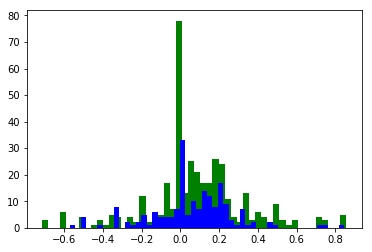

In [5]:
for val in results_de:
    print val
    print len(results_de[val])
    print len(results_en[val])

move_coh_de = results_de['Move coherence']
move_coh_en = results_en['Move coherence']

import matplotlib.pyplot as plt
%matplotlib inline

print 'DE: mean', np.mean(move_coh_de), ' SD', np.var(move_coh_de)**0.5
print 'EN: mean', np.mean(move_coh_en), ' SD', np.var(move_coh_en)**0.5

plt.hist(move_coh_de, bins=50, facecolor='green')
plt.hist(move_coh_en, bins=50, facecolor='blue')

plt.show()

In [12]:
for var in results_all:
    print var
    ttest =  stats.ttest_ind(results_de[var],results_en[var])
    if ttest[1] < 0.05:
        print str(ttest)+'\tSignificantly different'
    else:
        print ' Not significantly different'

Move coherence
 Not significantly different
Move alignment e-utts
 Not significantly different
Move alignment p-utts
Ttest_indResult(statistic=-2.1118224131313297, pvalue=0.035041787291629149)	Significantly different
Move players coherence
 Not significantly different
Move players alignment
 Not significantly different
Move coherence p-utts
 Not significantly different
Move coherence e-utts
 Not significantly different
Move alignment
Ttest_indResult(statistic=-2.6020341475152562, pvalue=0.0094324424329012384)	Significantly different


In [6]:
def compute_values_game(refexps_dir, success_dir):
    splits = compound_splitter.load_dict('de_lower.dict')
    game_level_align = []
    game_level_coherence = []
    playergame_level_align_speaker = defaultdict(list)
    playergame_level_coherence_speaker = defaultdict(list)

    for dialogue in listdir(refexps_dir):
        if dialogue.startswith('FTT'):
            language = 'german'
        else:
            language = 'english'
        dialogue = load_data(path.join(refexps_dir, dialogue))
        dialogue_game = gamerun_level(dialogue)
        for obj in dialogue_game:
            refobj = dialogue_game[obj]
            sim_align = []
            sim_align_speaker = defaultdict(list)
            sim_coherence_speaker = defaultdict(list)
            sim_coherence = []
            for ref in refobj:
                speaker = ref[1]
                sim = len_div(ref, get_previous(ref, refobj), language, splits)
                if sim != 'undefined':
                    sim_align.append(sim)
                    sim_align_speaker[speaker].append(sim)
            sim_align = np.mean(sim_align)
            for s in sim_align_speaker[speaker]:
                sim_align_speaker[speaker] = np.mean(sim_align_speaker[speaker])
            comb_ref = combinations(refobj,2)
            for comb in comb_ref:
                if comb[0] != comb[1]:
                    sim = len_div(comb[0], comb[1], language, splits)
                    if sim != 'undefined':
                        sim_coherence.append(sim)
                        sim_coherence_speaker[comb[0][1]].append(sim)
                        sim_coherence_speaker[comb[1][1]].append(sim)
            sim_coherence = np.mean(sim_coherence)
            #gamelevel coherence and alignment (for each object)
            if not np.isnan(sim_coherence) :
                game_level_coherence.append(sim_coherence)
            if not np.isnan(sim_align):
                game_level_align.append(sim_align)
            for s in sim_align_speaker:
                if not np.isnan(np.mean(sim_align_speaker[s])):
                    playergame_level_align_speaker[s].append(np.mean(sim_align_speaker[s]))
            for s in sim_coherence_speaker:
                if not np.isnan(np.mean(sim_coherence_speaker[s])) :
                    playergame_level_coherence_speaker[s].append(np.mean(sim_coherence_speaker[s]))

    game_level_align_all = []
    game_level_coherence_all = []

    playergame_level_align_speaker_all = defaultdict(list)
    playergame_level_coherence_speaker_all = defaultdict(list)

    results_game = defaultdict(list)

    playergame_level_coherence = []
    for s in playergame_level_coherence_speaker:
        playergame_level_coherence += playergame_level_coherence_speaker[s]
        playergame_level_coherence_speaker_all[s] += playergame_level_coherence_speaker[s]
        results_game['game coherence '+ s] = playergame_level_coherence_speaker[s]
    results_game['game players coherence'] = playergame_level_coherence
    results_game['game coherence'] = game_level_coherence
    playergame_level_align = []
    for s in playergame_level_align_speaker:
        playergame_level_align += playergame_level_align_speaker[s]
        playergame_level_align_speaker_all[s] += playergame_level_align_speaker[s]
        results_game['game alignment '+ s] = playergame_level_align_speaker[s]
    results_game['game players alignment'] = playergame_level_align
    results_game['game alignment'] = game_level_align
    for value in results_game:
        dataset = results_game[value]
        print '\t'+ value + ': '
        print '\tMean: '+ str(np.mean(dataset)) +'\tStandard deviation: '+ str(np.std(dataset))
        print '\tMax value: ' + str(max(dataset)) + '\tMin value: '+ str(min(dataset))
    return results_game

In [7]:

results_de = compute_values_game(de_dataset_dir, de_success_dir)
print '\n\n'
results_en = compute_values_game(en_dataset_dir, en_success_dir)
print '\n\n'
results_all = compute_values_game(all_dataset_dir, all_success_dir)

	game players coherence: 
	Mean: 0.040450574686	Standard deviation: 0.212982439353
	Max value: 0.75	Min value: -0.714285714286
	game coherence e-utts: 
	Mean: 0.00825552395049	Standard deviation: 0.201387597148
	Max value: 0.714285714286	Min value: -0.714285714286
	game alignment: 
	Mean: 0.325837749306	Standard deviation: 0.206608932337
	Max value: 0.9	Min value: 0.0
	game alignment p-utts: 
	Mean: 0.357771022414	Standard deviation: 0.221177529976
	Max value: 0.9	Min value: 0.0
	game coherence p-utts: 
	Mean: 0.0587397819113	Standard deviation: 0.217180916909
	Max value: 0.75	Min value: -0.714285714286
	game players alignment: 
	Mean: 0.287057123297	Standard deviation: 0.258095865203
	Max value: 0.9	Min value: -0.789473684211
	game coherence: 
	Mean: 0.052970850732	Standard deviation: 0.218244834174
	Max value: 0.75	Min value: -0.714285714286
	game alignment e-utts: 
	Mean: 0.142261996533	Standard deviation: 0.26765526509
	Max value: 0.636363636364	Min value: -0.789473684211



	game 

In [15]:
for var in results_all:
    print var
    ttest =  stats.ttest_ind(results_de[var],results_en[var])
    if ttest[1] < 0.05:
        print str(ttest)+'\tSignificantly different'
    else:
        print ' Not significantly different'

game players coherence
 Not significantly different
game coherence e-utts
 Not significantly different
game alignment
 Not significantly different
game alignment p-utts
 Not significantly different
game coherence p-utts
 Not significantly different
game players alignment
 Not significantly different
game coherence
 Not significantly different
game alignment e-utts
 Not significantly different
